In [1]:
#pip
!pip install torchvision

In [2]:
# Imports
import pandas as pd
import os
import numpy as np
from numpy.distutils.misc_util import is_sequence
from bs4 import BeautifulSoup #this is to extract info from the xml, if we use it in the end
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import json
import pickle

import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler 
from sklearn.metrics import f1_score, precision_score, recall_score
import statistics 

import os
from datetime import datetime 
from pathlib import Path 


In [3]:
local_mode = True 
if local_mode:
    batch_size = 75
    num_epochs = 2
    epoch_partial_num = 1
    selfcsv_df = pd.read_csv("frame_MasterList.csv").head(900)  
    dir_path = os.getcwd()
else:
    batch_size = 128
    num_epochs = 100
    epoch_partial_num = 100
    selfcsv_df = pd.read_csv("frame_MasterList.csv")
    dir_path = "/scratch/sa3ag/modelRuns"

In [4]:
try:
    current_time = datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p") 
    directory = dir_path+"/"+current_time+"_NOTEBOOK"
    if not os.path.exists(directory):
        os.makedirs(directory)
    print(f'Creation of directory at {directory} successful')
except:
    print(f'Creation of directory at {directory} failed')


Creation of directory at /Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/2020_12_27-11_56_09_PM_NOTEBOOK successful


In [5]:
file_output_path = directory+"/"

In [6]:
# Get label and encode
def get_box(obj):
    xmin = float(obj.find('xmin').text)
    xmax = float(obj.find('xmax').text)
    ymin = float(obj.find('ymin').text)
    ymax = float(obj.find('ymax').text)
    return [xmin, ymin, xmax, ymax]

def get_label(obj):
    if obj.find('name').text == 'person' or obj.find('name').text == 'people':
        return 1
    if obj.find('name').text == 'cyclist':
        return 2
    else:
        return 0

# Generate the target location in the image
def generate_target(image_id,file):
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml') #probably will have to change this
        objects = soup.find_all('object')

        num_objs = len(objects)

        boxes = []
        labels = []

        for i in objects:
            boxes.append(get_box(i))
            labels.append(get_label(i))
            
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        img_id = torch.tensor([image_id])

        # Creating the target for the box
        target={}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = img_id

        return target

def OHE(label):
  if label == "People" or label== "Person":
      return 1
  elif label == "Cyclist":
      return 2
  else:
      return 0

def Recode(label):
  if label == 1:
      return "Person(s)"
  elif label == 2:
      return "Cyclist"
  else:
      return "N/A"

class FullImages(object):
    def __init__(self, transforms=None):
        self.csv = selfcsv_df
        self.csv_len = self.csv.shape[1]
        self.imgs = self.csv.image_path.tolist()
        self.imgs_len = len(self.imgs)
        self.transforms = transforms

    def __len__(self):
        return self.imgs_len
        #return self.csv_len

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img = self.csv.loc[idx, 'image_path']
        annotation = self.csv.loc[idx, 'annotation_path']

        img = Image.open(img).convert("L")
        target = generate_target(idx, annotation)

        # label = self.labels[idx]
        # label = OHE(label)
        # label = torch.as_tensor(label, dtype=torch.int64)

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target


In [7]:
# Normalize
data_transform = transforms.Compose([#transforms.Resize((80,50)),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.5], [0.5]
                                                          )])

# Collate images
def collate_fn(batch):
    return tuple(zip(*batch)) #will need adjusting when pathing is adjusted

dataset = FullImages(data_transform)
data_size = len(dataset)
print(f'Length of Dataset: {data_size}')

indices = list(range(data_size))
test_split = 0.2
split = int(np.floor(test_split * data_size))
#print(f'Length of Split Dataset: {split}')

train_indices, test_indices = indices[split:], indices[:split]
len_train_ind, len_test_ind = len(train_indices), len(test_indices)
print(f'Length of Train: {len_train_ind}; Length of Test: {len_test_ind}')


Length of Dataset: 900
Length of Train: 720; Length of Test: 180


In [8]:

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size = batch_size,
    sampler = train_sampler,
    collate_fn = collate_fn
)

len_dataloader = len(data_loader)
print(f'Length of train: {len_dataloader}')

data_loader_test = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler = test_sampler, collate_fn = collate_fn)
len_testdataloader = len(data_loader_test)
print(f'Length of test: {len_testdataloader}')


Length of train: 10
Length of test: 3


In [9]:
# Check if GPU
cuda = torch.cuda.is_available()
if cuda:
    device = torch.device("cuda")
    print(f'CUDA device')
else:
    device = torch.device("cpu")
    print(f'CPU device')

# Instance segmentation is crucial in using the full images
def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(
        in_features, num_classes)
    return model


CPU device


In [10]:
for test_imgs, test_annotations in data_loader_test:
    imgs_test = list(img_test.to(device) for img_test in test_imgs)
    annotations_test = [{k: v.to(device) for k, v in t.items()} for t in test_annotations]

for train_imgs, train_annotations in data_loader:
    imgs_train = list(img_train.to(device) for img_train in train_imgs)
    annotations_train = [{k: v.to(device) for k, v in t.items()} for t in train_annotations]
    
print(f'{len_testdataloader} batches in test data loader.')
print(f'{len_dataloader} batches in test data loader.')


3 batches in test data loader.
10 batches in test data loader.


In [11]:
test_annotations_list = []
for dictionary in test_annotations:
  annotation = dictionary['image_id']
  test_annotations_list.append(annotation)
  
train_annotations_list = []
for dictionary in train_annotations:
  annotation = dictionary['image_id']
  train_annotations_list.append(annotation)
  
print(f'{len(test_annotations_list)} unique image ids in test annotations')
print(f'{len(train_annotations_list)} unique image ids in train annotations')

30 unique image ids in test annotations
45 unique image ids in train annotations


In [12]:
#cnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = False)
model = get_model_instance_segmentation(3)
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params) #, lr = 0.005, weight_decay = 0.0005)

In [13]:

tot_ats = 0
epochs = 0
epoch_ats = []
epoch_losses = []
df = pd.DataFrame({'Mean_Epoch_Loss': epoch_losses}) 
for epoch in range(num_epochs):
    epochs += 1
    print(f'Epoch: {epochs}')
    model.train()
    epoch_loss = 0
    i = 0
    for train_imgs, train_annotations in data_loader:
        imgs = list(img.to(device) for img in train_imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in train_annotations]
        loss_dict = model([imgs[0]], [annotations[0]])
        losses = sum(loss for loss in loss_dict.values())
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        i += 1
        tot_ats += 1 
    
        epoch_loss += losses
        print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')
        
    
    mean_epoch_loss = epoch_loss/i
    epoch_losses.append(mean_epoch_loss)
    epoch_ats.append(i)
    
    if epochs % epoch_partial_num == 0:
        df = pd.DataFrame({'Mean_Epoch_Loss': epoch_losses})  
        #print(df)
        partial_name = "full_model_partial_" + str(epochs)     
        df.to_csv(file_output_path+partial_name+ "_losses.csv", index=False)
        torch.save(model.state_dict(), file_output_path+partial_name + ".pt") 
        print(f'Partial model and losses for epoch {file_output_path} saved to {directory}.')    
        
    # Update learning rate
    #lr_scheduler.step()

try:
    # Save training metrics
    full_name = "full_model_losses_" + str(epochs) + ".csv"
    df.to_csv(file_output_path+full_name, index=False)
    print(f'Full model losses for {epochs} epochs saved to {directory}.') 
except:
    pass

try:
    # Save model
    torch.save(model.state_dict(), file_output_path+'full_model.pt')
    print(f'Full model trained on {epochs} epochs saved to {directory}.')     
except:
    pass

print(f'Annotations Trained: {tot_ats}')

# model2 = get_model_instance_segmentation(3)
# model2.load_state_dict(torch.load(file_output_path+'full_model.pt'))
# model2.eval()
# model2.to(device)


Epoch: 1


Iteration: 1/10, Loss: 2.356196880340576


Iteration: 2/10, Loss: 0.8706722855567932


Iteration: 3/10, Loss: 240.96087646484375


Iteration: 4/10, Loss: 1.5320158004760742


Iteration: 5/10, Loss: 1.9071145057678223


Iteration: 6/10, Loss: 0.9390219449996948


Iteration: 7/10, Loss: 0.5133472084999084


Iteration: 8/10, Loss: 1.8854634761810303


Iteration: 9/10, Loss: 0.5180153250694275


Iteration: 10/10, Loss: 0.5825377106666565


Partial model and losses for epoch /Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/2020_12_27-11_56_09_PM_NOTEBOOK/ saved to /Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/2020_12_27-11_56_09_PM_NOTEBOOK.
Epoch: 2


Iteration: 1/10, Loss: 0.17834559082984924


Iteration: 2/10, Loss: 1.2086557149887085


Iteration: 3/10, Loss: 1.5842185020446777


Iteration: 4/10, Loss: 0.5560025572776794


Iteration: 5/10, Loss: 0.4682253301143646


Iteration: 6/10, Loss: 0.9382421970367432


Iteration: 7/10, Loss: 0.36070820689201355


Iteration: 8/10, Loss: 0.3295859694480896


Iteration: 9/10, Loss: 0.8506429195404053


Iteration: 10/10, Loss: 0.22749388217926025


Partial model and losses for epoch /Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/2020_12_27-11_56_09_PM_NOTEBOOK/ saved to /Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/2020_12_27-11_56_09_PM_NOTEBOOK.
Full model losses for 2 epochs saved to /Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/2020_12_27-11_56_09_PM_NOTEBOOK.


Full model trained on 2 epochs saved to /Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/2020_12_27-11_56_09_PM_NOTEBOOK.
Annotations Trained: 20


In [14]:
epoch_ats


[10, 10]

In [15]:

test_annotations_list = []
for dictionary in test_annotations:
  annotation = dictionary['image_id']
  test_annotations_list.append(annotation)
  
train_annotations_list = []
for dictionary in train_annotations:
  annotation = dictionary['image_id']
  train_annotations_list.append(annotation)
  
print(f'{len(test_annotations_list)} unique image ids in test annotations')
print(f'{len(train_annotations_list)} unique image ids in train annotations')

30 unique image ids in test annotations
45 unique image ids in train annotations


In [16]:
master_csv = pd.read_csv("frame_MasterList.csv")
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

In [17]:
preds_train = model(train_imgs)
print(len(preds_train))
print(preds_train)


45


[{'boxes': tensor([[ 80.2111, 164.3095, 101.8913, 361.3830],
        [ 69.9723, 164.5698,  91.6818, 361.1510],
        [359.8284, 388.7303, 389.8051, 485.7221],
        [ 90.4915, 194.4276, 112.1047, 392.3517],
        [ 27.8215, 263.0798, 114.1192, 367.3281],
        [ 28.0739, 221.9060, 114.6069, 325.9150],
        [349.6415, 388.6042, 379.5394, 485.5694],
        [ 59.7580, 165.0541,  81.4489, 360.5394],
        [ 42.5056, 388.9761,  72.3762, 485.5847],
        [ 39.1586, 205.7739,  60.7881, 401.2482],
        [ 39.3554, 274.7598,  60.9693, 461.0255],
        [ 52.7557, 389.0118,  82.6179, 485.5614],
        [ 32.2813, 388.8611,  62.1223, 485.5084],
        [339.4691, 388.5751, 369.2962, 485.4630],
        [ 49.6327, 266.7153,  71.2599, 459.1892],
        [ 80.5051, 256.3710, 102.0292, 454.0298],
        [100.8344, 194.6873, 122.3570, 391.9539],
        [ 59.9115, 257.1738,  81.5247, 453.2892],
        [ 70.2273, 256.6157,  91.7854, 453.7965],
        [ 28.0440, 180.9995, 113.6511, 

In [18]:
preds_test = model(test_imgs)
print(len(preds_test))
print(preds_test)


30
[{'boxes': tensor([[ 26.4191, 180.3929, 116.2985, 285.7898],
        [ 39.9945,  96.9723,  61.7115, 308.8469],
        [ 28.8971, 110.1815,  51.0054, 316.7008],
        [ 26.8367, 221.3046, 116.8393, 326.2855],
        [ 50.4949,  97.1325,  72.1512, 309.1306],
        [ 26.4346, 139.5211, 115.6663, 245.1329],
        [ 13.4638, 102.7775,  58.2850, 289.2014],
        [ 60.8245,  97.9617,  82.4867, 308.4789],
        [ 71.0047,  98.4240,  92.6911, 308.0359],
        [ 81.1259,  98.8300, 102.8516, 307.6180],
        [ 91.3061,  99.0469, 113.0384, 307.4248],
        [101.5419,  99.1028, 123.2416, 307.2137],
        [ 28.6944,  48.9541,  50.7158, 236.1858],
        [ 27.1286,  99.0402, 116.1430, 203.1896],
        [ 30.5159,  65.1188, 130.0428, 160.8279],
        [111.0070, 142.7733, 132.9748, 343.7334],
        [121.2639, 142.8933, 143.1942, 343.6104],
        [ 17.1645, 112.2799,  39.6729, 313.1981],
        [ 27.2948, 262.8874, 115.7463, 367.5181],
        [131.5269, 143.2735, 153.405

In [22]:

len(annotations)


45

In [21]:

len(test_annotations)

45

In [23]:
if preds_train == preds_test:
    print(f'Train predictions EQUAL test predictions.')
else:
    print(f'Train predictions DO NOT EQUAL test predictions.')

Train predictions DO NOT EQUAL test predictions.


In [24]:
def get_iou(num, input, test = False):
    if test:
        identifier = "Test"
        annotation = annotations_test[num]
        prediction = preds_test[num]
    else:
        identifier = "Train"
        annotation = annotations[num]
        prediction = preds_train[num]
    
    annotation_boxes = annotation["boxes"].tolist()
    
    ix = 0
    for box in annotation["boxes"]:
        img_id = annotation["image_id"].item()
        file_name = master_csv.loc[img_id,:].image_path
        set = file_name.split("/")[7]
        video = file_name.split("/")[8]
        file_name = file_name.split("/")[10]
        file_name = file_name[:-4]
        output_name = set+"_"+video+"_"+file_name
        ix += 1  

    ix = 0
    voc_iou = []
    print(f'{len(prediction["boxes"])} prediction boxes made for {len(annotation["boxes"])} actual boxes in {str(output_name)} for {identifier} with note {input}')
    for box in prediction["boxes"]:
        xmin, ymin, xmax, ymax = box.tolist()
        iou_list = []
        for bound in annotation_boxes:
            a_xmin, a_ymin, a_xmax, a_ymax = bound
            xA = max(xmin, a_xmin)
            yA = max(ymin, a_ymin)
            xB = min(xmax, a_xmax)
            yB = min(ymax, a_ymax)
            interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
            p_area = (xmax - xmin + 1) * (ymax - ymin + 1)
            a_area = (a_xmax - a_xmin + 1) * (a_ymax - a_ymin + 1)
            iou = interArea / float(p_area + a_area - interArea)
            iou_list.append(iou)
        max_val = max(iou_list) 
        voc_iou.append(max_val)
        ix += 1
        
    if len(voc_iou) == 0:
        mean_iou = 0
        print(f'No predictions made so Mean IOU: {mean_iou}')
    else:
        mean_iou = sum(voc_iou)/len(voc_iou)
    
    return [mean_iou, voc_iou]

def plot_images(num, input):
    fig, ax = plt.subplots(nrows=1, ncols=2)
    img_tensor = imgs[num]
    annotation = annotations[num]
    # for key, value in annotation.items():
    #         print(key, value)
    prediction = preds_train[num]
    
    img = img_tensor.cpu().data
    img = img[0,:,:]
    
    ax[0].imshow(img, cmap='gray')
    ax[1].imshow(img, cmap='gray')
    
    ix = 0
    for box in annotation["boxes"]:
        #print(annotations[ix])
        xmin, ymin, xmax, ymax = box.tolist()
        value = annotation["labels"][ix]
        img_id = annotation["image_id"].item()
        file_name = master_csv.loc[img_id,:].image_path
        set = file_name.split("/")[7]
        video = file_name.split("/")[8]
        file_name = file_name.split("/")[10]
        file_name = file_name[:-4]
        output_name = set+"_"+video+"_"+file_name
        text = Recode(value)
        colors = ["r", "#00FF00",  "#0000FF"]
        rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin), linewidth=1,
                                 edgecolor=colors[value], facecolor='none')
        target_x = xmin
        target_y = ymin - 5
        ax[0].text(target_x, target_y, text, color=colors[value])
        ax[0].add_patch(rect)
        ix += 1
        

    ix = 0
    print(str(len(prediction["boxes"])) + " prediction boxes made for " + str(len(annotation["boxes"])) + " actual boxes in " + str(output_name))
    for box in prediction["boxes"]:
        xmin, ymin, xmax, ymax = box.tolist()
        value = prediction["labels"][ix]
        text = Recode(value)
        colors = ["r", "#00FF00",  "#0000FF"]
        rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin), linewidth=1,
                                 edgecolor=colors[value], facecolor='none')
        target_x = xmin
        target_y = ymin - 5
        ax[1].text(target_x, target_y, text, color=colors[value])
        ax[1].add_patch(rect)
        ix += 1
        
    #figname = file_name+"_"+input+".png"
    #fig.savefig(figname)
    plt.show()
    
# A predicted bounding box is considered correct if it overlaps more than 50% with a ground-truth bounding box, otherwise the bounding box is considered a false positive detection. Multiple detections are penalized. If a system predicts several bounding boxes that overlap with a single ground-truth bounding box, only one prediction is considered correct, the others are considered false positives.

### AFTER INTERIM: 
# Use get_iou to store set, video, frame, annotation boxes, pred boxes, lists of iou
# Dictionary like {cyclist: [IOU, IOU, IOU], people: [IOU, IOU]}

def plot_iou(num, input, test = False):
    fig, ax = plt.subplots(1)
    if test:
        identifier = "Test" 
        print(identifier)
        img_tensor = imgs_test[num]
        annotation = annotations_test[num]
        prediction = preds_test[num]
    else:
        identifier = "Train" 
        print(identifier)
        img_tensor = imgs[num]
        annotation = annotations[num]
        prediction = preds_train[num]
    
    img = img_tensor.cpu().data
    img = img[0,:,:]
    annotation_boxes = annotation["boxes"].tolist()  
    
    ax.imshow(img, cmap='gray')
    
    ix = 0
    for box in annotation["boxes"]:
        xmin, ymin, xmax, ymax = box.tolist()
        value = annotation["labels"][ix]
        img_id = annotation["image_id"].item()
        file_name = master_csv.loc[img_id,:].image_path
        set = file_name.split("/")[7]
        video = file_name.split("/")[8]
        file_name = file_name.split("/")[10]
        file_name = file_name[:-4]
        output_name = set+"_"+video+"_"+file_name+"_"+identifier
        text = Recode(value)
        colors = ["r", "r", "r"]
        rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin), linewidth=1,
                                 edgecolor=colors[value], facecolor='none')
        target_x = xmin
        target_y = ymin - 5
        ax.text(target_x, target_y, text, color=colors[value])
        ax.add_patch(rect)
        ix += 1  

    ix = 0
    voc_iou = []
    print(f'{len(prediction["boxes"])} prediction boxes made for {len(annotation["boxes"])} actual boxes in {str(output_name)} for {identifier} with note {input} (INDEX {num})')
    for box in prediction["boxes"]:
        xmin, ymin, xmax, ymax = box.tolist()
        
        iou_list = []
        for bound in annotation_boxes:
            a_xmin, a_ymin, a_xmax, a_ymax = bound
            xA = max(xmin, a_xmin)
            yA = max(ymin, a_ymin)
            xB = min(xmax, a_xmax)
            yB = min(ymax, a_ymax)
            interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
            p_area = (xmax - xmin + 1) * (ymax - ymin + 1)
            a_area = (a_xmax - a_xmin + 1) * (a_ymax - a_ymin + 1)
            iou = interArea / float(p_area + a_area - interArea)
            iou_list.append(iou)
        max_val = max(iou_list) 
        voc_iou.append(max_val)

        max_ix = iou_list.index(max_val)
        map_dict = {max_ix: max_val} 
        
        #iou_string = ', '.join((str(float) for float in iou_list))
        value = prediction["labels"][ix]
        text = json.dumps(map_dict)
        colors = ["r", "#00FF00",  "#0000FF"]
        rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin), linewidth=1,
                                 edgecolor=colors[value], facecolor='none')
        target_x = xmin
        target_y = ymin - 5
        ax.text(target_x, target_y, text, color=colors[value])
        ax.add_patch(rect)
        ix += 1
    
    plt.show()
    
    if len(voc_iou) == 0:
        mean_iou = 0
        print(f'No predictions made so Mean IOU: {mean_iou}')
    else:
        mean_iou = sum(voc_iou)/len(voc_iou)
        fp = voc_iou.count(0)/len(voc_iou) * 100
        bp = sum((i > 0 and i < 0.5) for i in voc_iou)/len(voc_iou) * 100
        gp = sum((i >= 0.5) for i in voc_iou)/len(voc_iou) * 100
        print(f'{fp} false positives (IOU = 0)') 
        print(f'{bp} bad positives (0 < IOU < 0.5)')
        print(f'{gp} good positives (IOU >= 0.5)')
        print(f'Mean IOU: {mean_iou}')

    figname = output_name+"_"+input+".png"
    fig.savefig(file_output_path+figname)
    print(f'Figure {figname} saved to {directory}.')  




In [26]:
print(f'Train is {len(preds_train)} and test is {len(preds_test)}')

Train is 45 and test is 30


100 prediction boxes made for 1 actual boxes in set01_V001_I00267


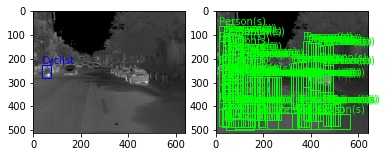

In [27]:
plot_images(0, "first")

Train
100 prediction boxes made for 1 actual boxes in set01_V001_I00267_Train for Train with note first (INDEX 0)


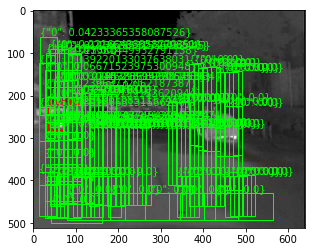

81.0 false positives (IOU = 0)
19.0 bad positives (0 < IOU < 0.5)
0.0 good positives (IOU >= 0.5)
Mean IOU: 0.02489726881976698
Figure set01_V001_I00267_Train_first.png saved to /Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/2020_12_27-11_56_09_PM_NOTEBOOK.


Train
100 prediction boxes made for 4 actual boxes in set01_V003_I00611_Train for Train with note last (INDEX 44)


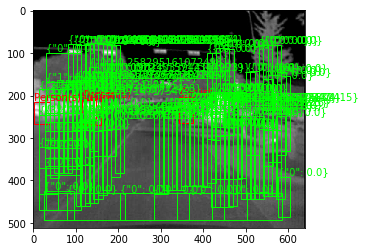

72.0 false positives (IOU = 0)
28.000000000000004 bad positives (0 < IOU < 0.5)
0.0 good positives (IOU >= 0.5)
Mean IOU: 0.03142208388762962


Figure set01_V003_I00611_Train_last.png saved to /Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/2020_12_27-11_56_09_PM_NOTEBOOK.


In [28]:
plot_iou(0, "first", False)
plot_iou(len(preds_train)-1, "last", False)

In [29]:

get_iou(len(preds_train)-1, "last", False)[0]

100 prediction boxes made for 4 actual boxes in set01_V003_I00611 for Train with note last


0.03142208388762962

Test
100 prediction boxes made for 1 actual boxes in set01_V002_I01276_Test for Test with note first (INDEX 0)


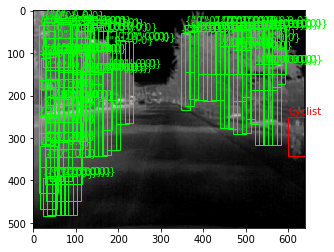

100.0 false positives (IOU = 0)
0.0 bad positives (0 < IOU < 0.5)
0.0 good positives (IOU >= 0.5)
Mean IOU: 0.0


Figure set01_V002_I01276_Test_first.png saved to /Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/2020_12_27-11_56_09_PM_NOTEBOOK.
Test
100 prediction boxes made for 3 actual boxes in set01_V003_I00654_Test for Test with note last (INDEX 29)


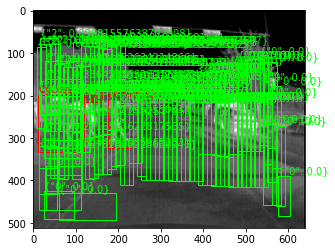

56.00000000000001 false positives (IOU = 0)
42.0 bad positives (0 < IOU < 0.5)
2.0 good positives (IOU >= 0.5)
Mean IOU: 0.09065172514682435
Figure set01_V003_I00654_Test_last.png saved to /Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/2020_12_27-11_56_09_PM_NOTEBOOK.


In [30]:
plot_iou(0, "first", True)
plot_iou(len(preds_test)-1, "last", True)

In [31]:
get_iou(len(preds_test)-1, "last", True)[0]


100 prediction boxes made for 3 actual boxes in set01_V003_I00654 for Test with note last


0.09065172514682435

In [32]:
iou_df_train = pd.DataFrame(columns=["Train_Mean_IOU", "IOU_List"])
for train_pred in range(0, len(preds_train)):
    iou_function = get_iou(train_pred, "first", False)
    len_df = len(iou_df_train)
    iou_df_train.loc[len_df,:] = iou_function
    try:
        if train_pred % 50 == 0:
            partial_name = "partial_iou_TRAIN_" + str(train_pred) + "_images.csv" 
            iou_df_train.to_csv(file_output_path+partial_name, index=False)
            print(f'Partial train IOUs for {len(iou_df_train)} images saved to {directory}.') 
    except:
        pass
        
iou_df_train_name = "full_iou_TRAIN_" + str(epochs) + ".csv"
iou_df_train.to_csv(file_output_path+iou_df_train_name, index=False)
print(f'Full train IOUs for {len(iou_df_train)} images saved to {directory}.') 


100 prediction boxes made for 1 actual boxes in set01_V001_I00267 for Train with note first
Partial train IOUs for 1 images saved to /Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/2020_12_27-11_56_09_PM_NOTEBOOK.
100 prediction boxes made for 1 actual boxes in set01_V001_I00265 for Train with note first
100 prediction boxes made for 2 actual boxes in set01_V002_I01267 for Train with note first
100 prediction boxes made for 1 actual boxes in set01_V002_I00630 for Train with note first
100 prediction boxes made for 4 actual boxes in set01_V001_I00134 for Train with note first
100 prediction boxes made for 1 actual boxes in set01_V002_I01254 for Train with note first
100 prediction boxes made for 3 actual boxes in set01_V001_I00203 for Train with note first
100 prediction boxes made for 4 actual boxes in set01_V000_I01896 for Train with note first
100 prediction boxes made for 4 actual boxes in set01_V001_I00141 for Train with note first
100 prediction boxes made for 4 ac

100 prediction boxes made for 4 actual boxes in set01_V003_I00601 for Train with note first
100 prediction boxes made for 4 actual boxes in set01_V003_I00606 for Train with note first
100 prediction boxes made for 4 actual boxes in set01_V003_I00611 for Train with note first
Full train IOUs for 45 images saved to /Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/2020_12_27-11_56_09_PM_NOTEBOOK.


In [33]:
print(iou_df_train.sort_values(by='Train_Mean_IOU', ascending=False).head(5))

   Train_Mean_IOU                                           IOU_List
40       0.106168  [0.3512665419630211, 0.35115834417197556, 0.34...
41       0.088301  [0.44019711573646597, 0.0, 0.0, 0.375866414705...
7        0.082793  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0813866071951...
21      0.0686416  [0.20907073157123224, 0.07168430808737705, 0.3...
19      0.0616235  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...


In [34]:
iou_df_test = pd.DataFrame(columns=["Test_Mean_IOU", "IOU_List"])
for test_pred in range(0, len_testdataloader):
    iou_function = get_iou(test_pred, "test", False)
    len_df = len(iou_df_test)
    iou_df_test.loc[len_df,:] = iou_function
    try:
        if test_pred % 50 == 0:
            partial_name = "partial_iou_TEST_" + str(test_pred) + "_images.csv" 
            iou_df_test.to_csv(file_output_path+partial_name, index=False)
            print(f'Partial train IOUs for {len(iou_df_test)} images saved to {directory}.') 
    except:
        pass
        
iou_df_test_name = "full_iou_TEST_" + str(epochs) + ".csv"
iou_df_test.to_csv(file_output_path+iou_df_test_name, index=False)
print(f'Full train IOUs for {len(iou_df_test)} images saved to {directory}.') 


100 prediction boxes made for 1 actual boxes in set01_V001_I00267 for Train with note test
Partial train IOUs for 1 images saved to /Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/2020_12_27-11_56_09_PM_NOTEBOOK.
100 prediction boxes made for 1 actual boxes in set01_V001_I00265 for Train with note test
100 prediction boxes made for 2 actual boxes in set01_V002_I01267 for Train with note test
Full train IOUs for 3 images saved to /Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/2020_12_27-11_56_09_PM_NOTEBOOK.


In [35]:
print(iou_df_test.sort_values(by='Test_Mean_IOU', ascending=False).head(5))

  Test_Mean_IOU                                           IOU_List
0     0.0248973  [0.0, 0.046298389611155934, 0.0, 0.0, 0.072593...
1     0.0210892  [0.15547641492189962, 0.023550541478407273, 0....
2     0.0051938  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...


In [36]:
max_train_ix = iou_df_train[iou_df_train['Train_Mean_IOU'] == iou_df_train['Train_Mean_IOU'].max()].index.tolist()[0]
max_test_ix = iou_df_test[iou_df_test['Test_Mean_IOU'] == iou_df_test['Test_Mean_IOU'].max()].index.tolist()[0]


In [38]:

max_train_ix

40

Train
100 prediction boxes made for 5 actual boxes in set01_V003_I00736_Train for Train with note best (INDEX 40)


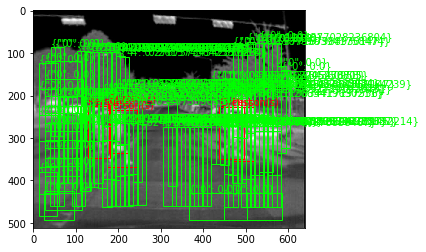

49.0 false positives (IOU = 0)
51.0 bad positives (0 < IOU < 0.5)
0.0 good positives (IOU >= 0.5)
Mean IOU: 0.1061678957587964


Figure set01_V003_I00736_Train_best.png saved to /Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/2020_12_27-11_56_09_PM_NOTEBOOK.


In [39]:
plot_iou(max_train_ix, "best", False)


Test
100 prediction boxes made for 1 actual boxes in set01_V002_I01276_Test for Test with note best (INDEX 0)


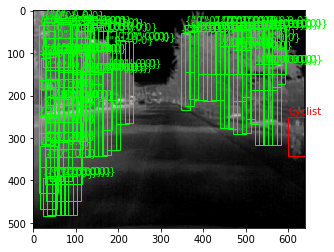

100.0 false positives (IOU = 0)
0.0 bad positives (0 < IOU < 0.5)
0.0 good positives (IOU >= 0.5)
Mean IOU: 0.0


Figure set01_V002_I01276_Test_best.png saved to /Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/2020_12_27-11_56_09_PM_NOTEBOOK.


In [40]:
plot_iou(max_test_ix, "best", True)


In [41]:
print(f'Train Mean IOU: {iou_df_train["Train_Mean_IOU"].mean()}')
print(f'Test Mean IOU: {iou_df_test["Test_Mean_IOU"].mean()}')

Train Mean IOU: 0.029819717042812617
Test Mean IOU: 0.01706008584770061
